# Surface examples
*Note that for many (almost all) cases you will be better off using pycortex; this simply provides a couple of alternative methods, should you want to do that.*

Also make sure you have the relevant stuff installed ()

I have created several tools for plotting data on the cortical surface. This will of course require that you have surface data (i.e., run freesurfer); and any data you want to plot will need to be in a vertex wise format. pycortex (https://github.com/gallantlab/pycortex) is a very powerful way of plotting information on the cortical surface and an excellent tool. Many of the tools here are already developed in pycortex. But I have 'remade' them. The main reason for doing this is to improve my understanding of surface plotting generally, and also to improve my understanding of pycortex. 

If you want to do some simple, quick and dirty stuff these tools might be useful. Also it can be useful to have the cortical mesh in a generic format readable by any 3D rendering software (e.g., .ply), and in a way that you can send a single file anywhere, and it be instantly readable, with color and everything. 

A basic overview on how to do the surface plotting. Including: 

[1] Freeview based 

[2] Blender

[3] Generic .ply format



*Note that for many (almost all) cases you will be better off using pycortex; this simply provides a couple of alternative methods, should you want to do that.*

In [22]:
%load_ext autoreload
%autoreload 2
import numpy as np


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


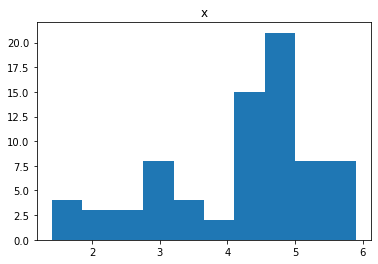

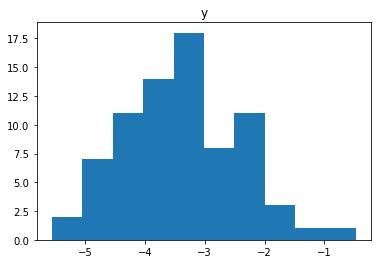

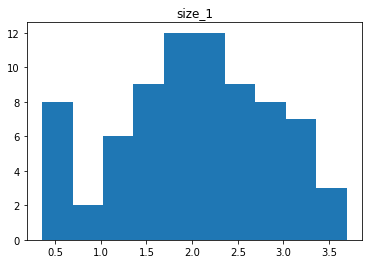

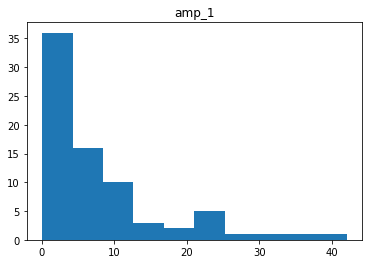

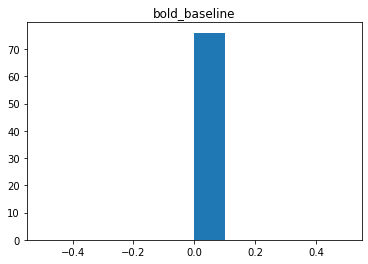

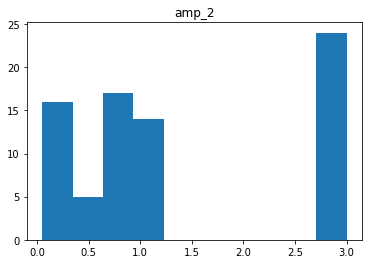

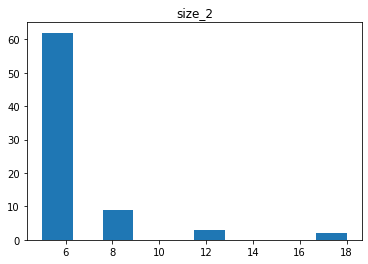

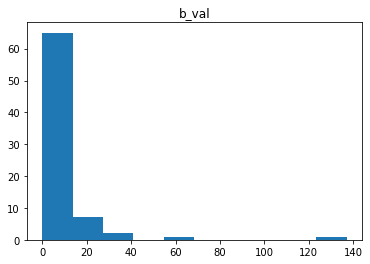

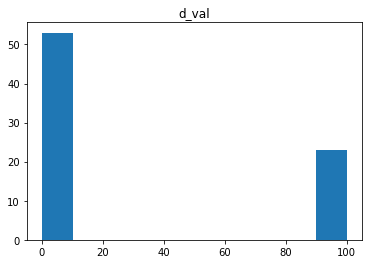

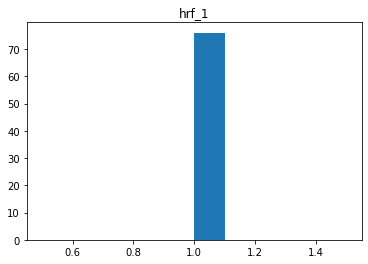

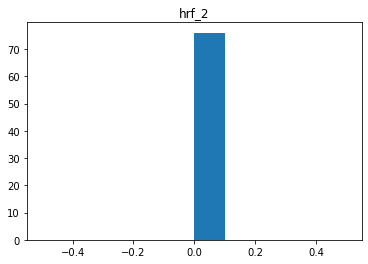

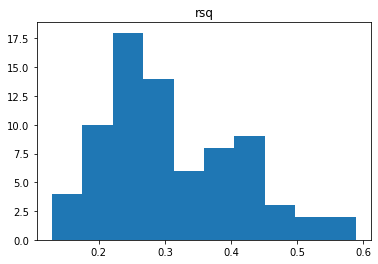

In [24]:
prf_obj.rapid_hist()

In [ ]:
sub = 'sub-01'                              # Subject number
fs_dir = 'your/path/to/freesurefer/folder'  # e.g., /home/project1/derivatives/freesurfer

# Load some data to plot on the surface (e.g., PRF eccentricity and polar angle):
# -> should 1D np.ndarray, where the length = number of vertices in subject surface
polar_angle_data = np.load('path/to/subjects/polar/angle/data')
eccentricity_data = np.load('path/to/subjects/polar/angle/data')

# ** Control visibility of data ** [using mask, or alpha, or both...] 
# If you don't want to show the values of every point (for example because it is outside the visual cortex). You may want to hide it. 
# data_mask: what to show (TRUE), what to hide (FALSE)
# -> should boolean 1D np.ndarray, where the length = number of vertices in subject surface
# -> if unspecified, all surface functions assume TRUE for all voxels
data_mask = np.load('path/to/some/mask')

# data_alpha: transparency (invisible = 0), (opaque = 1).
# -> should be 1D np.ndarray, min=0, max=1.  where the length = number of vertices in subject surface
# -> you could for example take the rsquared values of PRF fits and use this to determine the visibility of the prf data...
data_alpha = np.load('path/to/some/alpha/values')


### [1] Using freeview
* requires freeview, and nibabel. 
* Specify the data, the mesh, and the mask (you can only use binary masking, the option for varying the transparency is not available here). 
* scripts will create a custom surf file, and the command (which contains the colormap info) to open it in freeview
* The colormap can be anything from matplotlib. Just specify the min and max values. (https://matplotlib.org/stable/tutorials/colors/colormaps.html)
* You can also specify the camera angle for when freeview opens, and ask it to automatically take a picture of the surface. This can be useful if you want to iterate through several subjects/surface plots and save the figures as pngs, but can't be bothered to sit and click again and again... 

In [ ]:
from dag_prf_utils.mesh_maker import FSMaker
fs = FSMaker(sub=sub,fs_dir=fs_dir)

# Add polar angle plot
fs.add_surface(
    data = polar_angle_data,
    surf_name = f'{sub}-polar_angle',    
    vmin = -3.14, vmax=3.14, # min and max values of polar anlge 
    data_mask=data_mask,
    cmap = 'hsv', # using hsv for polar angle, can use something else...
)

# Add eccentricity
fs.add_surface(
    data = eccentricity_data,
    surf_name = f'{sub}-eccentricity',    
    vmin = 0, vmax = 5, # min and max values of eccentricity
    data_mask=data_mask,
    cmap = 'jet', # using jet for polar angle, can use something else...
)

In [ ]:
# Now we can open one of the surfaces in freeview
fs.open_fs_surface(
    surf_name=f'{sub}-polar_angle',
    mesh = 'inflated',          # what type of surface? inflated? pial?
    )

In [ ]:
# Maybe we want to open with a specific cameram angle and take a screenshot?
fs.open_fs_surface(
    surf_name=f'{sub}-polar_angle',
    mesh = 'inflated',          # what type of surface? inflated? pial?
    do_scrn_shot = True,
    scr_shot_file = 'where/to/put/the/screenshot', # Optional...Can just put it in custom surf folder
    # *** camer angles ***
    azimuth = 10, zoom = 1, elevation=5, roll=0, 
    )

***

### Blender
* requires freesurfer and blender
* This is the most powerful approach and allows for a lot of customization (due to the blender api flexibility, which can be called via python)
* The script will load the inflated and pial mesh, with the option to slide between the 2 (i.e. customize how inflated you want the surface to be)
* You can load several colormaps at once, and flip between them 
* If you are feeling adventurous, you can even create an animation over time, (e.g., plot timecourse info on the surface). This is a bit experimental, and may take up a lot of data and computing power. I haven't fully explored it. 


In [ ]:
from dag_prf_utils.blender_tools import BlendMaker
bm = BlendMaker(
    sub=sub,
    fs_dir=fs_dir,
    out_dir='where/to/save/the/blender/files',    
)
# This will create a folder with 4 .ply meshes
# -> left-inflated, right-inflated, left-pial, right-pial
# & 2 csv files with rgb information for:
# -> cortical curvature, cortical thickness

In [ ]:

# Add polar angle plot
bm.add_cmap(
    data=polar_angle_data,
    surf_name=f'{sub}-polar_angle',
    data_mask=data_mask,
    data_alpha=data_alpha,
    vmin = -3.14, vmax=3.14, # min and max values of polar anlge 
    cmap = 'hsv',
)
# Add eccentricity
bm.add_cmap(
    data=polar_angle_data,
    surf_name=f'{sub}-polar_angle',
    data_mask=data_mask,
    data_alpha=data_alpha,
    vmin = -3.14, vmax=3.14, # min and max values of polar anlge 
    cmap = 'hsv',
)

# This will add 2 more csv files with rgb information for:
# -> polar_angle, and eccentricity

In [ ]:
# Now we can launch blender, and load in the .ply files and the rgb data...
bm.launch_blender()


This may take a while. But once it is done, you can save everything together as one .blender file. You can open this file on its own, and everything will load very quickly. (so you only need to run this once, unless you change the data...)

You can then do a number of cool things:

* Inflate & deflate the hemispheres:    
    * Select the hemisphere (click on it; it should then have an orange line outlining it). 
    * Click on the green triangle on the panel on the right
    * Got to "shape keys"
    * Click on interpolated
    * There is a slider named "Value". Change the value here from 0-1 to inflate & deflate the hemisphere
* Switch between different plots:
    * Select the hemisphere (click on it)
    * Click on the green triangle on the panel on the right
    * Go to color attributes
    * Click on what you want to show on the surface (e.g., polar_angle, curvature etc.)

***

### Generic .ply format
* requires freesurfer 
* Specify the data, the mesh, and the mask (including an option for variable transparency). 
* can create a single .ply file (per hemisphere), which contains all the information about the mesh (vx coordinates, face id); the data values for each vertex, and a color value for each vertex (determined by the data, and specified colormap). 
* This can be opened by most 3D viewing software (e.g., meshlab, blender)...


In [ ]:
from dag_prf_utils.mesh_maker import dag_fs_to_ply

dag_fs_to_ply(
    sub=sub, 
    data=polar_angle_data, 
    fs_dir=fs_dir, 
    mesh_name='inflated',                   # Could be pial
    out_dir='where/to/save/the/ply/files',  # Output (multiple .ply files)
    under_surf='curv',                      # What is going underneath the data (e.g., curvature)
    # *** OPTIONAL ***
    data_mask = data_mask,
    data_alpha = data_alpha, 
    surf_name = f'{sub}-polar_angle',
    cmap = 'hsv',
    vmin = -3.14, vmax=3.14,
    )
# Now you can just navigate to out dir, and view the surface (.ply) file using any 3D renderer (e.g., meshlab, blender)

# ... same again, but for eccentricity...
dag_fs_to_ply(
    sub=sub, 
    data=eccentricity_data, 
    fs_dir=fs_dir, 
    mesh_name='inflated',                   # Could be pial
    out_dir='where/to/save/the/ply/files',  # Output (multiple .ply files)
    under_surf='curv',                      # What is going underneath the data (e.g., curvature)
    # *** OPTIONAL ***
    data_mask = data_mask,
    data_alpha = data_alpha, 
    surf_name = f'{sub}-eccentricity',
    cmap = 'jet',
    vmin = 0, vmax=5,
    )